<a href="https://colab.research.google.com/github/codeflickr/mobApp/blob/main/CNNGRULSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.python.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import GRU, LSTM, Dropout, Bidirectional
from tensorflow.python.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import rmsprop_v2, adam_v2
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import initializers 


In [3]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
stopw = pd.read_csv('/content/sample_data/Common Swahili Stop-words.csv', encoding='latin')
data = pd.read_excel('/content/sample_data/Iddy_Dataset.xlsx')

 **Text Preprocessing**

In [22]:
data[:5]

,category,text
0,Leg,Imeisha hiyoooooo
1,Leg,Next season tupo likizo
2,Leg,SHIRIKA LA UMEME TANZANIA (TANESCO)
3,Leg,TAARIFA YA KATIZO LA UMEME- MKOA WA DODOMA
4,Leg,Shirika la Umeme Tanzania (TANESCO) linawatang...


In [7]:
data

,category,text
0,Leg,Imeisha hiyoooooo
1,Leg,Next season tupo likizo
2,Leg,SHIRIKA LA UMEME TANZANIA (TANESCO)
3,Leg,TAARIFA YA KATIZO LA UMEME- MKOA WA DODOMA
4,Leg,Shirika la Umeme Tanzania (TANESCO) linawatang...
...,...,...
62629,Spam,Nitumie pesa sh elfu 50 Mama yako yupo hospita...
62630,Spam,Mwanao kalazwa ana hali mbaya sana kapata ajal...
62631,Spam,"tumia namba hii ya Aitel 0785133208,kutuma iyo..."
62632,Spam,iyo ela tuma kwenye namba hii ya TIGO jina 071...


In [23]:
# Removing Punctuations 
import string
def text_preprocess(text):
  nopun = [char for char in text if char not in string.punctuation]
  nopun = ''.join(nopun)
  return ' '.join([word.lower() for word in nopun.split() if word.lower() not in stopw.values])

In [24]:
data.rename(columns={'category' : 'v1', 'text': 'v2'}, inplace= True)

In [27]:
data['v2'] = data.v2.apply(text_preprocess)
data['v1'] = data.v1.apply(text_preprocess)

In [29]:
# Creating one hot for label
data['v1'] = data['v1'].map({'leg': 0, 'spam':1})

In [30]:
data

,v1,v2
0,0,imeisha hiyoooooo
1,0,next season tupo likizo
2,0,shirika umeme tanzania tanesco
3,0,taarifa katizo umeme mkoa dodoma
4,0,shirika umeme tanzania tanesco linawatangazia ...
...,...,...
62629,1,nitumie pesa sh elfu 50 mama yupo hospital ben...
62630,1,mwanao kalazwa ana hali mbaya kapata ajali ina...
62631,1,tumia namba aitel 0785133208kutuma iyo pesa ji...
62632,1,iyo ela tuma namba tigo jina 0712856647 jina f...


In [31]:
#balancing the dataset by downsampling the ham category
data1 = data[data['v1']==0]
data2 = data[data['v1']==1]
data3 = data1.sample(data2.shape[0])
data4 = pd.concat([data3,data2])

In [ ]:
data4

<ipython-input-32-03b16ec6fc07>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  count = len(data4[data.v1==i])


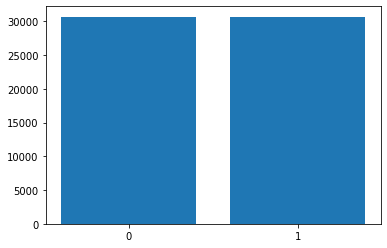

In [32]:
#plotting the distribution of the data
classes = data4.v1.unique()
counts = []
for i in classes:
  count = len(data4[data.v1==i])
  counts.append(count)
plt.bar(['0', '1'], counts)
plt.show()

In [33]:
data4.shape

(61350, 2)

Spliting training, Validation and Test set

In [34]:
y= data4.v1.values
x = data4.v2.values

In [35]:
x.shape

(61350,)

In [36]:
# Tokenization
tokeni = Tokenizer()
tokeni.fit_on_texts(x)
seq = tokeni.texts_to_sequences(x)

In [37]:
seq

[[361, 643, 485, 4633, 4634],
 [6238, 253, 467, 4635, 6239, 2310, 6240, 5296, 2945, 162],
 [17006, 103, 3304],
 [2170, 2678, 628, 17007],
 [6241, 2171, 17008, 23],
 [376, 719, 746],
 [17009, 17010],
 [189],
 [3305, 109, 720, 2679, 17011, 2172],
 [3811, 17012, 7740, 10129],
 [259, 3106, 7741, 17013, 4636, 17014, 178],
 [231,
  2117,
  5297,
  19,
  629,
  501,
  10130,
  1813,
  654,
  2078,
  2803,
  17015,
  17016,
  2078,
  7742,
  869],
 [205, 17017, 11, 17018, 17019, 17020, 17021, 5298, 981, 10131, 858],
 [17022],
 [17023, 3539, 17024, 7743, 17025, 3812, 3306],
 [210, 2804, 3813, 291],
 [250, 376, 302, 5299, 295, 793, 10132, 17026, 10133],
 [448, 2246, 6242, 10134, 1764, 2173, 212, 448, 10135, 10136, 10137],
 [10138, 28, 6243, 10139, 213, 1649, 7744, 3814, 5300, 10140, 303, 232],
 [174, 2311, 3107, 17027],
 [332, 2680, 891, 644, 2805],
 [130, 17028, 7745, 17029],
 [6244, 361, 322, 1693, 3307, 10141, 5301, 1572],
 [17030, 7746, 7747, 3540, 6245],
 [7748, 6246, 2459, 3308],
 [764, 10

In [38]:
# Vocaburaly Length 
vocab_size = len(tokeni.word_index)+1
# Finding the average size of each seq
#sum([len(i) for i in seq]) // len(seq)
vocab_size

43176

In [39]:
max_len = 30
embedding_size = 100
batch_size = 16
seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
seq.shape

(61350, 30)

In [40]:
x_train, x_test, y_train, y_test = train_test_split(seq,y, test_size=0.1,
                                                    random_state=0)
x_train1, x_val, y_train1, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

In [41]:
initial = tf.keras.layers.Dense(units=30, kernel_initializer= initializers.RandomNormal(stddev=0.01),
                       bias_initializer = initializers.Ones())

**LSTM**

In [42]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
model.add(Dense(units=30, kernel_initializer= initializers.RandomNormal(stddev=0.01),
                       bias_initializer = initializers.Ones()))
model.add(LSTM(30, return_sequences=True))
model.add(Dense(60))
model.add(Dropout(0.15))
model.add(LSTM(60, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.01))
model.add(Dense(1, activation='sigmoid', name='Classification'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           4317600   
_________________________________________________________________
dense (Dense)                (None, 30, 30)            3030      
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 30, 30)            7320      
_________________________________________________________________
dense_1 (Dense)              (None, 30, 60)            1860      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 30, 60)            0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 30, 60)            29040     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 30, 60)            0

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [43]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
epoch = 10
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
results = model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size, 
                    verbose=1, validation_data=(x_val, y_val), callbacks=[callback])

Epoch 1/10
3451/3451 [==============================] - 290s 82ms/step - loss: 0.6801 - accuracy: 0.5234 - val_loss: 0.6968 - val_accuracy: 0.4904
Epoch 2/10
3451/3451 [==============================] - 286s 83ms/step - loss: 0.5582 - accuracy: 0.6024 - val_loss: 0.0091 - val_accuracy: 0.9980
Epoch 3/10
3451/3451 [==============================] - 286s 83ms/step - loss: 0.0096 - accuracy: 0.9978 - val_loss: 0.0070 - val_accuracy: 0.9978
Epoch 4/10
3451/3451 [==============================] - 290s 84ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 7.9735e-04 - val_accuracy: 0.9996
Epoch 5/10
3451/3451 [==============================] - 287s 83ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 4.6450e-04 - val_accuracy: 1.0000
Epoch 6/10
3451/3451 [==============================] - 286s 83ms/step - loss: 9.3105e-04 - accuracy: 0.9998 - val_loss: 3.3126e-04 - val_accuracy: 0.9998
Epoch 7/10
3451/3451 [==============================] - 288s 83ms/step - loss: 8.7609e-04 - accuracy: 

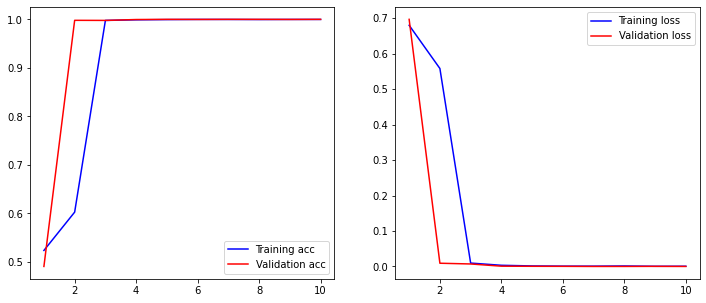

In [45]:
# plotting Summary of Histroy
def plot_model_results(result):
  acc= result.history['accuracy']
  val_acc= result.history['val_accuracy']
  loss= result.history['loss']
  val_loss= result.history['val_loss']

  x= range(1, len(acc)+1)

  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label= 'Validation acc')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.legend()

plot_model_results(results)

In [46]:
from sklearn import metrics

In [47]:
y_pred = np.where(model.evaluate(x_test,y_test))
print (metrics.classification_report(y_test,y_test))

192/192 [==============================] - 3s 15ms/step - loss: 6.0260e-05 - accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3020
           1       1.00      1.00      1.00      3115

    accuracy                           1.00      6135
   macro avg       1.00      1.00      1.00      6135
weighted avg       1.00      1.00      1.00      6135



**GRU Model**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           4317600   
_________________________________________________________________
module_wrapper_6 (ModuleWrap (None, 30, 100)           0         
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 30, 30)            11880     
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 30, 30)            0         
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 30, 60)            16560     
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 30, 60)            0         
_________________________________________________________________
module_wrapper_11 (ModuleWra (None, 30)               

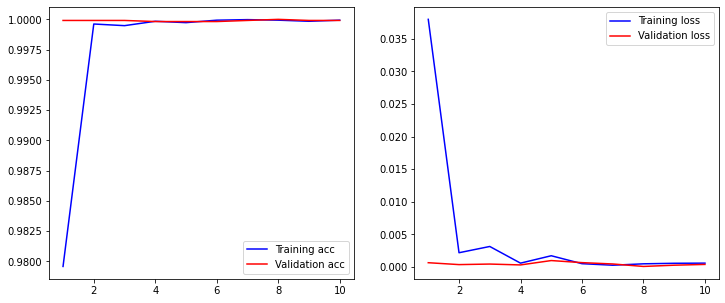

In [48]:
grumodel = Sequential()
grumodel.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
grumodel.add(Dropout(0.5))
grumodel.add(GRU(30, return_sequences=True))
grumodel.add(Dropout(0.3))
grumodel.add(GRU(60, return_sequences=True))
grumodel.add(Dropout(0.2))
grumodel.add(GRU(30, return_sequences=False))
grumodel.add(Dense(1, activation='sigmoid', name='classification'))
grumodel.summary()

grumodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

result1 = grumodel.fit(x_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2)

plot_model_results(result1)

In [49]:
y_pred = np.where(grumodel.evaluate(x_test,y_test))
print (metrics.classification_report(y_test,y_test))

192/192 [==============================] - 3s 13ms/step - loss: 0.0012 - accuracy: 0.9995
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3020
           1       1.00      1.00      1.00      3115

    accuracy                           1.00      6135
   macro avg       1.00      1.00      1.00      6135
weighted avg       1.00      1.00      1.00      6135



In [ ]:
tf.keras.layers.optimizer.Adam()

**BiDirectional LSTM**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           4317600   
_________________________________________________________________
module_wrapper_12 (ModuleWra (None, 30, 100)           0         
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 30, 60)            31440     
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 30, 60)            0         
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 30, 120)           58080     
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 30, 120)           0         
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 60)               

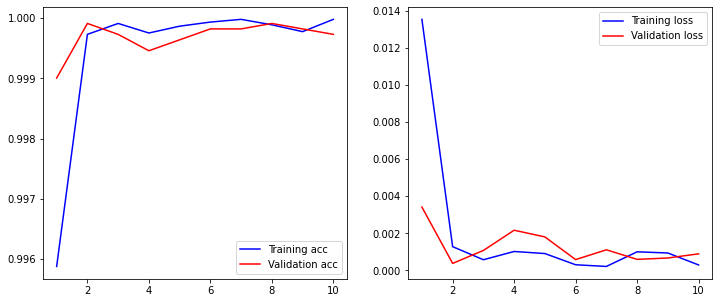

In [50]:
bilstmodel = Sequential()
bilstmodel.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
bilstmodel.add(Dropout(0.4))
bilstmodel.add(Bidirectional(LSTM(30, return_sequences=True)))
bilstmodel.add(Dropout(0.2))
bilstmodel.add(Bidirectional(LSTM(60, return_sequences=True)))
bilstmodel.add(Dropout(0.2))
bilstmodel.add(Bidirectional(LSTM(30, return_sequences=False)))
bilstmodel.add(Dense(1, activation='sigmoid', name='classification'))
bilstmodel.summary()

bilstmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
biresults= bilstmodel.fit(x_train, y_train, epochs=epoch, batch_size=batch_size, validation_split=0.2)

plot_model_results(biresults)

**CNN Model**

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           4317600   
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 128)           38528     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 128)            0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 9, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 128)            49280     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
module_wrapper_19 (ModuleWra (None, 128)              

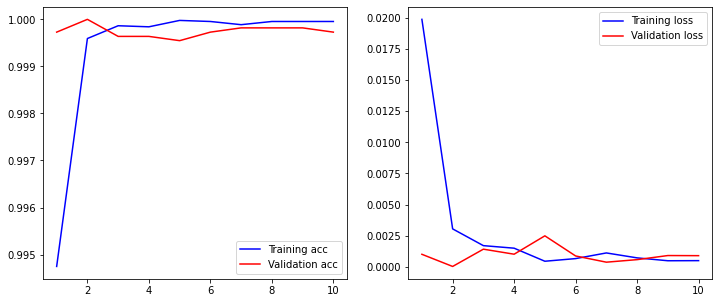

In [51]:
from tensorflow.python.keras.layers.pooling import MaxPool1D
cnnmodel = Sequential()
cnnmodel.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
cnnmodel.add(Conv1D(128, 3, activation='relu'))
cnnmodel.add(MaxPool1D(3))
cnnmodel.add(Dropout(0.2))
cnnmodel.add(Conv1D(128, 3, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dropout(0.2))
cnnmodel.add(Dense(64, activation='relu'))
cnnmodel.add(Dropout(0.2))
cnnmodel.add(Dense(32, activation='relu'))
cnnmodel.add(Dropout(0.2))
cnnmodel.add(Dense(1, activation='sigmoid'))
cnnmodel.summary()

cnnmodel.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])

cnnresults = cnnmodel.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, validation_split=0.2, verbose=1)

plot_model_results(cnnresults)